## Load environment

In [1]:
!rm -rf ./CityLearn_garage/
!git clone https://github.com/shttksm/CityLearn_garage.git

Cloning into 'CityLearn_garage'...
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 141 (delta 40), reused 124 (delta 26), pack-reused 0
Receiving objects: 100% (141/141), 11.92 MiB | 17.24 MiB/s, done.
Resolving deltas: 100% (40/40), done.


In [2]:
# Loading libraries
import sys
sys.path.append("./CityLearn_garage")

from citylearn import CityLearn
from reward_function import reward_function_ma
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from agent import RL_Agents_Coord

import os
import gym
import numpy as np
#from stable_baselines3 import SAC
#from stable_baselines3.sac.policies import MlpPolicy as MlpPolicy_SAC
#from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt
from pathlib import Path
import time

import pandas as pd
import seaborn as sns

import pickle
import copy
from tqdm import tqdm

In [3]:
import torch as th
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data.dataset import Dataset, random_split

In [4]:
def get_env(climate_zone):
  # Load environment
  data_path = Path("./CityLearn_garage/data/Climate_Zone_"+str(climate_zone))
  building_attributes = data_path / 'building_attributes.json'
  weather_file = data_path / 'weather_data.csv'
  solar_profile = data_path / 'solar_generation_1kW.csv'
  building_state_actions = './CityLearn_garage/buildings_state_action_space.json'
  building_ids = ["Building_1","Building_2","Building_3","Building_4","Building_5","Building_6","Building_7","Building_8","Building_9"]
  #building_ids = ["Building_1"] # Changed here. From 9 buildings to single building
  objective_function = ['ramping','1-load_factor','average_daily_peak','peak_demand','net_electricity_consumption']

  # Contain the lower and upper bounds of the states and actions, to be provided to the agent to normalize the variables between 0 and 1.
  # Can be obtained using observations_spaces[i].low or .high
  env = CityLearn(data_path, 
                  building_attributes, 
                  weather_file, 
                  solar_profile, 
                  building_ids, 
                  buildings_states_actions = building_state_actions, 
                  cost_function = objective_function, 
                  verbose = 1, 
                  simulation_period=(0,8760-1), 
                  central_agent=True) # I changed here.
  # Provides information on Building type, Climate Zone, Annual DHW demand, Annual Cooling Demand, Annual Electricity Demand, Solar Capacity, and correllations among buildings
  building_info = env.get_building_information()  
  observations_spaces, actions_spaces = env.get_state_action_spaces()

  return env, building_ids, building_state_actions, building_info, observations_spaces, actions_spaces

In [5]:
env, building_ids, building_state_actions, building_info, observations_spaces, actions_spaces = get_env(2)

# Load stable-baselines3

In [6]:
pip install stable-baselines3

     |████████████████████████████████| 153kB 16.5MB/s 


In [7]:
from stable_baselines3 import SAC, A2C, PPO
from stable_baselines3.sac.policies import MlpPolicy as MlpPolicy_SAC
from stable_baselines3.common.evaluation import evaluate_policy

from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize

# Gather operation data from the expert (RBC controller)

In [8]:
num_interactions = int(8760 * 12)

In [9]:
if isinstance(env.action_space, gym.spaces.Box):
  expert_observations = np.empty((num_interactions,) + env.observation_space.shape)
  expert_actions = np.empty((num_interactions,) + (env.action_space.shape[0],))

In [10]:
class RBC_agent:
    def __init__(self, env):
        self.num_action = env.action_space.shape[0]

    def select_action_by_RBC(self, state):
        hour = state[2]                                                                                                                                                               
        action_rbc = None                                                                                                                                                             
        if hour >= 9 and hour <= 21:                                                                                                                                                  
            action_rbc = [-0.08] * self.num_action                                                                                                                                     
        else:                                                                                                                                                                         
            action_rbc = [0.091] * self.num_action                                                                                                                                       
                                                                                                                                                                                    
        action_rbc = np.array(action_rbc)

        return action_rbc     

In [11]:
rbc = RBC_agent(env)

In [12]:
obs = env.reset()

for i in tqdm(range(num_interactions)):
    action = rbc.select_action_by_RBC(obs)
    expert_observations[i] = obs
    expert_actions[i] = action
    obs, reward, done, info = env.step(action)
    if done:
        obs = env.reset()

  8%|▊         | 8540/105120 [00:03<00:34, 2826.93it/s]

Cumulated reward: -51726580620.15482


./CityLearn_garage/citylearn.py:530: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.state = np.array(self.state)
./CityLearn_garage/citylearn.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a)
./CityLearn_garage/citylearn.py:452: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.state = np.array(self.state)
  

Cost score: {'ramping': 1.0, '1-load_factor': 1.0, 'average_daily_peak': 1.0, 'peak_demand': 1.0, 'net_electricity_consumption': 1.0, 'total': 1.0}


 17%|█▋        | 17836/105120 [00:16<00:34, 2560.26it/s]

Cumulated reward: -51726580620.15482
Cost score: {'ramping': 1.0, '1-load_factor': 1.0, 'average_daily_peak': 1.0, 'peak_demand': 1.0, 'net_electricity_consumption': 1.0, 'total': 1.0}


 25%|██▌       | 26720/105120 [00:19<00:29, 2680.79it/s]

Cumulated reward: -51726580620.15482
Cost score: {'ramping': 1.0, '1-load_factor': 1.0, 'average_daily_peak': 1.0, 'peak_demand': 1.0, 'net_electricity_consumption': 1.0, 'total': 1.0}


 34%|███▍      | 35843/105120 [00:23<00:26, 2630.49it/s]

Cumulated reward: -51726580620.15482
Cost score: {'ramping': 1.0, '1-load_factor': 1.0, 'average_daily_peak': 1.0, 'peak_demand': 1.0, 'net_electricity_consumption': 1.0, 'total': 1.0}


 42%|████▏     | 44431/105120 [00:26<00:24, 2515.41it/s]

Cumulated reward: -51726580620.15482
Cost score: {'ramping': 1.0, '1-load_factor': 1.0, 'average_daily_peak': 1.0, 'peak_demand': 1.0, 'net_electricity_consumption': 1.0, 'total': 1.0}


 51%|█████     | 53176/105120 [00:29<00:20, 2579.51it/s]

Cumulated reward: -51726580620.15482
Cost score: {'ramping': 1.0, '1-load_factor': 1.0, 'average_daily_peak': 1.0, 'peak_demand': 1.0, 'net_electricity_consumption': 1.0, 'total': 1.0}


 59%|█████▊    | 61715/105120 [00:32<00:15, 2723.75it/s]

Cumulated reward: -51726580620.15482
Cost score: {'ramping': 1.0, '1-load_factor': 1.0, 'average_daily_peak': 1.0, 'peak_demand': 1.0, 'net_electricity_consumption': 1.0, 'total': 1.0}


 67%|██████▋   | 70487/105120 [00:35<00:12, 2698.78it/s]

Cumulated reward: -51726580620.15482
Cost score: {'ramping': 1.0, '1-load_factor': 1.0, 'average_daily_peak': 1.0, 'peak_demand': 1.0, 'net_electricity_consumption': 1.0, 'total': 1.0}


 76%|███████▌  | 79416/105120 [00:38<00:09, 2793.32it/s]

Cumulated reward: -51726580620.15482
Cost score: {'ramping': 1.0, '1-load_factor': 1.0, 'average_daily_peak': 1.0, 'peak_demand': 1.0, 'net_electricity_consumption': 1.0, 'total': 1.0}


 84%|████████▍ | 88340/105120 [00:41<00:06, 2746.24it/s]

Cumulated reward: -51726580620.15482
Cost score: {'ramping': 1.0, '1-load_factor': 1.0, 'average_daily_peak': 1.0, 'peak_demand': 1.0, 'net_electricity_consumption': 1.0, 'total': 1.0}


 92%|█████████▏| 96774/105120 [00:44<00:03, 2779.96it/s]

Cumulated reward: -51726580620.15482
Cost score: {'ramping': 1.0, '1-load_factor': 1.0, 'average_daily_peak': 1.0, 'peak_demand': 1.0, 'net_electricity_consumption': 1.0, 'total': 1.0}


100%|██████████| 105120/105120 [00:47<00:00, 2195.91it/s]

Cumulated reward: -51726580620.15482
Cost score: {'ramping': 1.0, '1-load_factor': 1.0, 'average_daily_peak': 1.0, 'peak_demand': 1.0, 'net_electricity_consumption': 1.0, 'total': 1.0}


In [13]:
np.savez_compressed(
    "rbc_data",
    expert_actions=expert_actions,
    expert_observations=expert_observations,
)

- To seamlessly use PyTorch in the training process, we subclass an `ExpertDataset` from PyTorch's base `Dataset`.
- Note that we initialize the dataset with the previously generated expert observations and actions.
- We further implement Python's `__getitem__` and `__len__` magic functions to allow PyTorch's dataset-handling to access arbitrary rows in the dataset and inform it about the length of the dataset.
- For more information about PyTorch's datasets, you can read: https://pytorch.org/docs/stable/data.html.

In [14]:
class ExpertDataSet(Dataset):
    def __init__(self, expert_observations, expert_actions):
        self.observations = expert_observations
        self.actions = expert_actions
        
    def __getitem__(self, index):
        return (self.observations[index], self.actions[index])

    def __len__(self):
        return len(self.observations)

In [15]:
expert_dataset = ExpertDataSet(expert_observations, expert_actions)

train_size = int(0.8 * len(expert_dataset))

test_size = len(expert_dataset) - train_size

train_expert_dataset, test_expert_dataset = random_split(
    expert_dataset, [train_size, test_size], generator=th.Generator('cuda:0')
)

In [16]:
print("test_expert_dataset: ", len(test_expert_dataset))
print("train_expert_dataset: ", len(train_expert_dataset))

test_expert_dataset:  21024
train_expert_dataset:  84096


NOTE: The supervised learning section of this code is adapted from: https://github.com/pytorch/examples/blob/master/mnist/main.py
1. We extract the policy network of our RL student agent.
2. We load the (labeled) expert dataset containing expert observations as inputs and expert actions as targets.
3. We perform supervised learning, that is, we adjust the policy network's parameters such that given expert observations as inputs to the network, its outputs match the targets (expert actions).
By training the policy network in this way the corresponding RL student agent is taught to behave like the expert agent that was used to created the expert dataset (Behavior Cloning).

In [17]:
# PPO parameters
use_cuda = th.cuda.is_available()
device   = th.device("cuda" if use_cuda else "cpu")
device

policy_kwargs = {}
policy_kwargs["net_arch"] = [dict(pi=[400, 300, 200], vf=[400, 300, 200])]

In [18]:
ppo_student = PPO("MlpPolicy", 
                  env, 
                  learning_rate = 0.001, # the original is 0.0003
                  verbose=0, 
                  policy_kwargs=policy_kwargs,
                  vf_coef=0.01
                  )

In [19]:
student = ppo_student

In [20]:
def pretrain_agent(
    student,
    batch_size=64,
    epochs=1000,
    scheduler_gamma=0.7,
    learning_rate=1.0,
    log_interval=100,
    no_cuda=True,
    seed=1,
    test_batch_size=64,
):
    use_cuda = not no_cuda and th.cuda.is_available()
    th.manual_seed(seed)
    device = th.device("cuda" if use_cuda else "cpu")
    kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

    if isinstance(env.action_space, gym.spaces.Box):
      criterion = nn.MSELoss()
    else:
      criterion = nn.CrossEntropyLoss()

    # Extract initial policy
    model = student.policy.to(device)

    def train(model, device, train_loader, optimizer):
        model.train()

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()

            if isinstance(env.action_space, gym.spaces.Box):
              # A2C/PPO policy outputs actions, values, log_prob
              # SAC/TD3 policy outputs actions only
              if isinstance(student, (A2C, PPO)):
                action, _, _ = model(data)
              else:
                # SAC/TD3:
                action = model(data)
              action_prediction = action.double()
            else:
              # Retrieve the logits for A2C/PPO when using discrete actions
              latent_pi, _, _ = model._get_latent(data)
              logits = model.action_net(latent_pi)
              action_prediction = logits
              target = target.long()

            loss = criterion(action_prediction, target)
            loss.backward()
            optimizer.step()
            if batch_idx % log_interval == 0:
                print(
                    "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                        epoch,
                        batch_idx * len(data),
                        len(train_loader.dataset),
                        100.0 * batch_idx / len(train_loader),
                        loss.item(),
                    )
                )
    def test(model, device, test_loader):
        model.eval()
        test_loss = 0
        with th.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)

                if isinstance(env.action_space, gym.spaces.Box):
                  # A2C/PPO policy outputs actions, values, log_prob
                  # SAC/TD3 policy outputs actions only
                  if isinstance(student, (A2C, PPO)):
                    action, _, _ = model(data)
                  else:
                    # SAC/TD3:
                    action = model(data)
                  action_prediction = action.double()
                else:
                  # Retrieve the logits for A2C/PPO when using discrete actions
                  latent_pi, _, _ = model._get_latent(data)
                  logits = model.action_net(latent_pi)
                  action_prediction = logits
                  target = target.long()

                test_loss = criterion(action_prediction, target)
        test_loss /= len(test_loader.dataset)
        print(f"Test set: Average loss: {test_loss:.4f}")

    # Here, we use PyTorch `DataLoader` to our load previously created `ExpertDataset` for training
    # and testing
    train_loader = th.utils.data.DataLoader(
        dataset=train_expert_dataset, batch_size=batch_size, shuffle=True, **kwargs
    )
    test_loader = th.utils.data.DataLoader(
        dataset=test_expert_dataset, batch_size=test_batch_size, shuffle=True, **kwargs,
    )

    # Define an Optimizer and a learning rate schedule.
    optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=1, gamma=scheduler_gamma)

    # Now we are finally ready to train the policy model.
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer)
        test(model, device, test_loader)
        scheduler.step()

    # Implant the trained policy network back into the RL student agent
    student.policy = model

In [21]:
mean_reward, std_reward = evaluate_policy(student, env, n_eval_episodes=1)

print(f"Mean reward = {mean_reward} +/- {std_reward}")

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


Cumulated reward: -68673693898.44089
Cost score: {'ramping': 0.87413293, '1-load_factor': 1.0744374909313852, 'average_daily_peak': 1.0314146, 'peak_demand': 1.245058, 'net_electricity_consumption': 1.0146086, 'total': 1.0479303224546181}
Mean reward = -68673693898.44089 +/- 0.0


In [22]:
pretrain_agent(
    student,
    epochs=20,
    scheduler_gamma=0.7,
    learning_rate=1.0,
    log_interval=100,
    no_cuda=True,
    seed=1,
    batch_size=64,
    test_batch_size=1000,
)

Train Epoch: 1 [0/84096 (0%)]	Loss: 1.084771
Train Epoch: 1 [6400/84096 (8%)]	Loss: 0.610512
Train Epoch: 1 [12800/84096 (15%)]	Loss: 0.317643
Train Epoch: 1 [19200/84096 (23%)]	Loss: 0.178970
Train Epoch: 1 [25600/84096 (30%)]	Loss: 0.100780
Train Epoch: 1 [32000/84096 (38%)]	Loss: 0.061510
Train Epoch: 1 [38400/84096 (46%)]	Loss: 0.037095
Train Epoch: 1 [44800/84096 (53%)]	Loss: 0.023119
Train Epoch: 1 [51200/84096 (61%)]	Loss: 0.014156
Train Epoch: 1 [57600/84096 (68%)]	Loss: 0.011501
Train Epoch: 1 [64000/84096 (76%)]	Loss: 0.010038
Train Epoch: 1 [70400/84096 (84%)]	Loss: 0.007078
Train Epoch: 1 [76800/84096 (91%)]	Loss: 0.006272
Train Epoch: 1 [83200/84096 (99%)]	Loss: 0.006045
Test set: Average loss: 0.0000
Train Epoch: 2 [0/84096 (0%)]	Loss: 0.005802
Train Epoch: 2 [6400/84096 (8%)]	Loss: 0.005893
Train Epoch: 2 [12800/84096 (15%)]	Loss: 0.004918
Train Epoch: 2 [19200/84096 (23%)]	Loss: 0.004684
Train Epoch: 2 [25600/84096 (30%)]	Loss: 0.004619
Train Epoch: 2 [32000/84096 (38%)

In [23]:
# save the pretrained model
dumpname = type(student).__name__ + "_student"
student.save(dumpname)

In [24]:
mean_reward, std_reward = evaluate_policy(student, env, n_eval_episodes=1)

print(f"Mean reward = {mean_reward} +/- {std_reward}")

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


Cumulated reward: -51321315674.930565
Cost score: {'ramping': 0.9690853, '1-load_factor': 0.9853203442133065, 'average_daily_peak': 0.97398436, 'peak_demand': 0.9924088, 'net_electricity_consumption': 0.9998787, 'total': 0.9841354995257973}
Mean reward = -51321315674.930565 +/- 0.0


In [25]:
# load from the dumped file.
student = type(student).load(dumpname)

## Additional training from the pre-trained policy weights

In [26]:
def eval_policy(env, ppo_student, deterministic=True):
    state = env.reset()
    done = False

    cum_reward = []
    action_hist = []
    hours = []
    i = 0

    while not done:
        action, _state = ppo_student.predict(state, deterministic=deterministic)
        #action = np.array([0, 0])
        #action = select_action(state)
        hours.append(f"{i}:" + str(state[2]))
        next_state, reward, done, _ = env.step(action)
        
        cum_reward.append(reward)
        action_hist.append(action[0])

        state = next_state
        
    cum_reward = np.array(cum_reward).sum()
    cost = env.cost()

    return cost, cum_reward, action_hist

In [27]:
student.set_env(env)
# ppo_student.set_env(env)

costs = []
cum_rewards = []
action_hists = []

for epoch in range(12):
    # Learn in one epcoch:year 
    student.learn(total_timesteps=8760)

    # evaluate the cumulated reward and cost diterministically
    # because, in the training process, the action is sampled from the distribution of policy.
    # it might cause to underestimate the policy.
    cost, cum_reward, action_hist = eval_policy(env, student)
    costs.append(cost)
    cum_rewards.append(cum_reward)
    action_hists.append(action_hist)

Cumulated reward: -51720437193.64776
Cost score: {'ramping': 0.9996511, '1-load_factor': 0.979206689117481, 'average_daily_peak': 0.9703268, 'peak_demand': 0.95199823, 'net_electricity_consumption': 1.0023632, 'total': 0.980709196710215}
Cumulated reward: -51208470408.782974
Cost score: {'ramping': 0.9629782, '1-load_factor': 0.9862806798145924, 'average_daily_peak': 0.96974015, 'peak_demand': 0.9965988, 'net_electricity_consumption': 0.99993664, 'total': 0.9831068873629125}
Cumulated reward: -51632419585.746445
Cost score: {'ramping': 0.9972075, '1-load_factor': 0.9858372206215398, 'average_daily_peak': 0.9695751, 'peak_demand': 0.9919972, 'net_electricity_consumption': 1.0022377, 'total': 0.9893709420109656}
Cumulated reward: -51176889968.67682
Cost score: {'ramping': 0.96005714, '1-load_factor': 0.9864453327915166, 'average_daily_peak': 0.96712047, 'peak_demand': 0.99604553, 'net_electricity_consumption': 0.9996745, 'total': 0.9818685939363856}
Cumulated reward: -51763783117.93923
C

In [28]:
eval_df = pd.DataFrame(costs)
eval_df['cum_reward'] = pd.Series(cum_rewards)

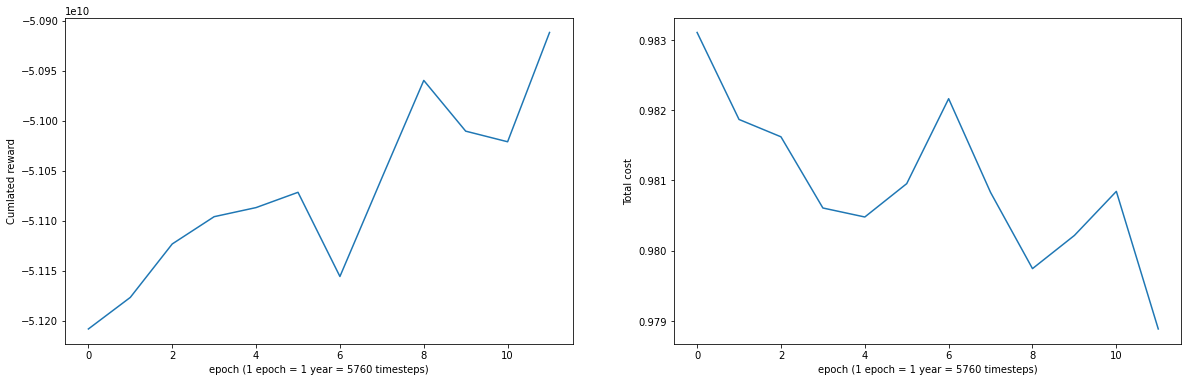

In [29]:
fig, axs = plt.subplots(1, 2, figsize = (20, 6))
axs[0].plot(eval_df["cum_reward"], label="a")
axs[0].set_ylabel("Cumlated reward")
axs[0].set_xlabel("epoch (1 epoch = 1 year = 5760 timesteps)")
axs[1].plot(eval_df["total"])
axs[1].set_ylabel("Total cost")
axs[1].set_xlabel("epoch (1 epoch = 1 year = 5760 timesteps)")
pass

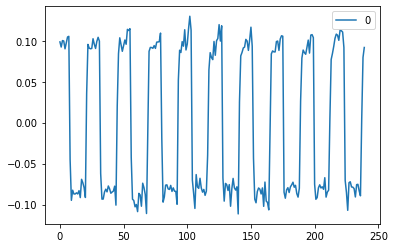

In [30]:
ax = pd.DataFrame(action_hists[-1]).iloc[:, :3][0:24*10].plot()

## Pre-training + PPO vs normal PPO from initial weights

In [31]:
# A2C and PPO parameters
use_cuda = th.cuda.is_available()
device   = th.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [32]:
args = {'batch_size': 16,
 'clip_range': 0.3,
 'ent_coef': 0.01,
 'gae_lambda': 0.98,
 'gamma': 0.9,
 'learning_rate': 0.1,
 'max_grad_norm': 0.8,
 'n_epochs': 5,
 'n_steps': 64,
 'policy_kwargs': {'activation_fn': th.nn.modules.activation.Tanh,
  'net_arch': [{'pi': [256, 256], 'vf': [256, 256]}]},
 'vf_coef': 0.5441028863071543}

In [33]:
ppo_nonstudent = PPO("MlpPolicy", 
                  env, 
                  **args
                  )

In [34]:
costs_ns = []
cum_rewards_ns = []
action_hists_ns = []

for epoch in range(12):
    # Learn in one epcoch:year 
    ppo_nonstudent.learn(total_timesteps=8760)
    # evaluate the cumulated reward and cost diterministically
    # because, in the training process, the action is sampled from the distribution of policy.
    # it might cause to underestimate the policy.
    print("--- eval")
    cost, cum_reward, action_hist = eval_policy(env, ppo_nonstudent)
    costs_ns.append(cost)
    cum_rewards_ns.append(cum_reward)
    action_hists_ns.append(action_hist)

Cumulated reward: -73335768343.07843
Cost score: {'ramping': 1.5016134, '1-load_factor': 1.150425749645375, 'average_daily_peak': 1.1499118, 'peak_demand': 1.2609998, 'net_electricity_consumption': 1.043043, 'total': 1.221198741123228}
--- eval
Cumulated reward: -69411321077.35614
Cost score: {'ramping': 0.874131, '1-load_factor': 1.076917035443149, 'average_daily_peak': 1.0356185, 'peak_demand': 1.2449315, 'net_electricity_consumption': 1.0155303, 'total': 1.0494256820405645}
Cumulated reward: -73001711018.1529
Cost score: {'ramping': 1.4998686, '1-load_factor': 1.1408893725237164, 'average_daily_peak': 1.1547947, 'peak_demand': 1.2574515, 'net_electricity_consumption': 1.0427985, 'total': 1.2191605500571114}
--- eval
Cumulated reward: -68832505134.83212
Cost score: {'ramping': 0.85657775, '1-load_factor': 1.0612333983151432, 'average_daily_peak': 1.0262792, 'peak_demand': 1.2345685, 'net_electricity_consumption': 1.0222139, 'total': 1.0401745551818276}
Cumulated reward: -73497441603.

In [35]:
eval_df_ns = pd.DataFrame(costs_ns)
eval_df_ns['cum_reward'] = pd.Series(cum_rewards_ns)

In [36]:
eval_df_ns

,ramping,1-load_factor,average_daily_peak,peak_demand,net_electricity_consumption,total,cum_reward
0,0.874131,1.076917,1.035619,1.244931,1.015530,1.049426,-6.941132e+10
1,0.856578,1.061233,1.026279,1.234568,1.022214,1.040175,-6.883251e+10
2,0.872771,1.073897,1.032346,1.231068,1.013827,1.044782,-6.845035e+10
3,0.868376,1.066855,1.021687,1.219124,1.011584,1.037525,-6.720378e+10
4,0.865997,1.072716,1.020433,1.225787,1.004338,1.037854,-6.577932e+10
5,0.866369,1.073813,1.023345,1.232962,1.005506,1.040399,-6.685842e+10
6,0.865215,1.074107,1.022318,1.232473,1.005823,1.039988,-6.717092e+10
7,0.860116,1.062925,1.018116,1.226517,1.009211,1.035377,-6.657888e+10
8,0.855625,1.070943,1.018830,1.229042,1.006127,1.036113,-6.650594e+10
9,0.855272,1.072010,1.018404,1.224590,1.005229,1.035101,-6.632581e+10


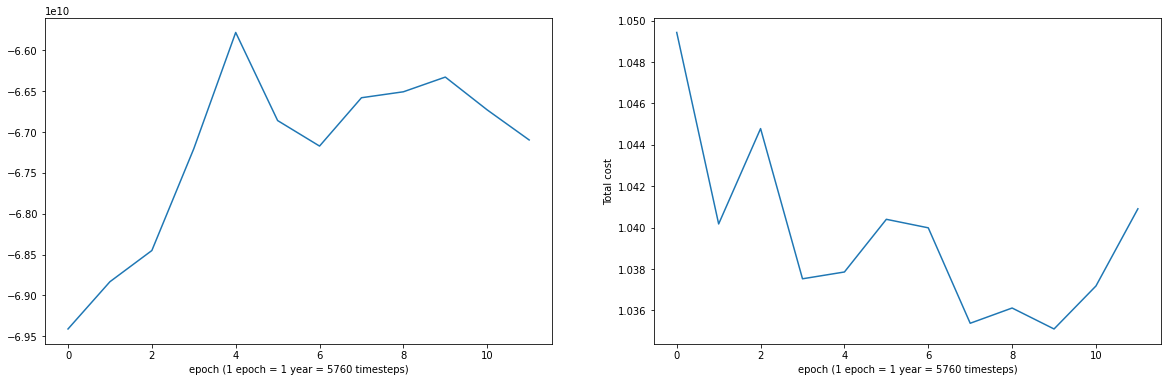

In [37]:
fig, axs = plt.subplots(1, 2, figsize = (20, 6))
axs[0].plot(eval_df_ns["cum_reward"], label="a")
axs[0].set_xlabel("epoch (1 epoch = 1 year = 5760 timesteps)")
axs[1].plot(eval_df_ns["total"])
axs[1].set_ylabel("Total cost")
axs[1].set_xlabel("epoch (1 epoch = 1 year = 5760 timesteps)")
pass

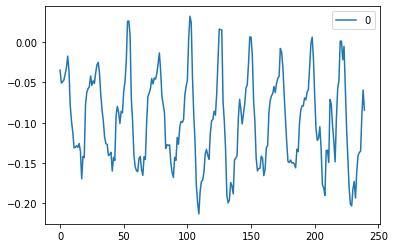

In [44]:
ax = pd.DataFrame(action_hists_ns[-1]).iloc[:, :3][0:24*10].plot()

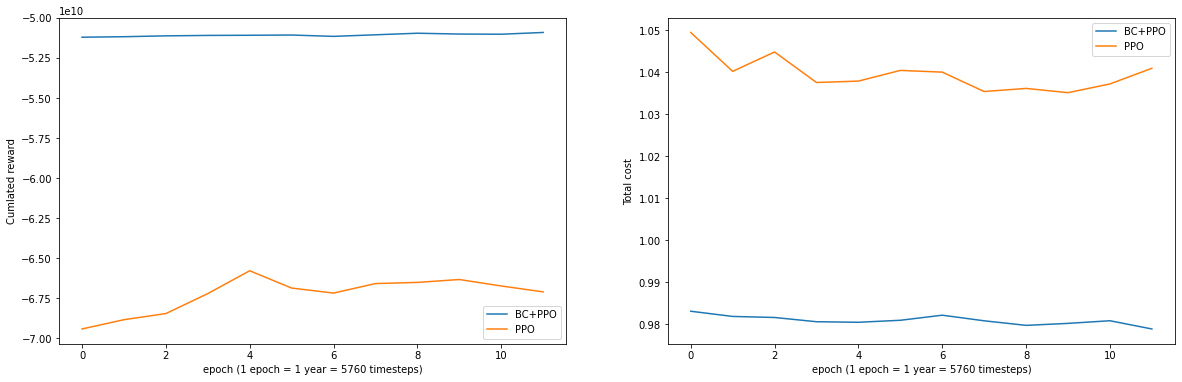

In [40]:
fig, axs = plt.subplots(1, 2, figsize = (20, 6))
axs[0].plot(eval_df["cum_reward"], label="BC+PPO")
axs[0].plot(eval_df_ns["cum_reward"], label="PPO")
axs[0].set_ylabel("Cumlated reward")
axs[0].set_xlabel("epoch (1 epoch = 1 year = 5760 timesteps)")
axs[0].legend()
axs[1].plot(eval_df["total"],label="BC+PPO")
axs[1].plot(eval_df_ns["total"],label="PPO")
axs[1].set_ylabel("Total cost")
axs[1].set_xlabel("epoch (1 epoch = 1 year = 5760 timesteps)")
axs[1].legend()
pass